In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
# Load Teams from KenPom and ESPN
from selenium import webdriver
from march_sadness import KPTeam, ESPNTeam, CombinedTeam


# Set up Selenium webdriver with GeckoDriver
options = webdriver.FirefoxOptions()
options.add_argument('-headless')
with webdriver.Firefox(options=options) as driver:
    kp_teams = KPTeam.list_all(driver)
print(f'Loaded {len(kp_teams)} teams from KenPom')

espn_teams = ESPNTeam.list_all()

print(f'Loaded {len(espn_teams)} teams from ESPN')


Loaded 363 teams from KenPom
Loaded 360 teams from ESPN


In [3]:
from fuzzywuzzy import fuzz


def edge_weight(espn_team: ESPNTeam, kp_team: KPTeam):
    # Special cases for the problem children
    if espn_team.id == '41' or kp_team.name == 'Connecticut':
        return 1 if espn_team.id == '41' and kp_team.name == 'Connecticut' else 0
    if espn_team.id == '82' or kp_team.name == 'Illinois Chicago':
        return 1 if espn_team.id == '82' and kp_team.name == 'Illinois Chicago' else 0
    if espn_team.id == '112358' or kp_team.name == 'LIU':
        return 1 if espn_team.id == '112358' and kp_team.name == 'LIU' else 0

    disp_ratio = fuzz.ratio(espn_team.displayName, kp_team.name)
    nick_ratio = fuzz.ratio(espn_team.nickname, kp_team.name)
    lin_weight = max(disp_ratio, nick_ratio) / 100
    return lin_weight


teams = CombinedTeam.combine(espn_teams, kp_teams, edge_weight)
print(f'Loaded {len(teams)} combined teams')


Loaded 360 combined teams


In [4]:
def get_team(name):
    def fuzz_name(x): return fuzz.ratio(name, x)

    def single_match(x): return fuzz_name(max(x.espn.displayName,
                                              x.espn.nickname, x.espn.abbreviation, x.kp.name, key=fuzz_name))
    match = max(teams, key=single_match)
    return match


In [5]:
def get_team_by_id(id):
    matches = [team for team in teams if team.espn.id == id]
    if len(matches) > 0:
        return matches[0]
    return None

In [6]:
import pandas as pd
from dataclasses import asdict
from IPython.display import display

def kpdata(matchupTeams):
    df = pd.DataFrame(({
        **{k: v for k, v in asdict(x.kp).items() if k not in ['name', 'conf']}
    } for x in matchupTeams), index=(x.espn.displayName for x in matchupTeams))
    df.loc['Difference'] = df.iloc[0] - df.iloc[1]
    return df


In [7]:
import requests


def get_schedule(team):
    if 'schedule' in team.misc:
        return team.misc['schedule']
    response = requests.get(f'https://site.api.espn.com/apis/site/v2/sports/basketball/mens-college-basketball/teams/{team.espn.id}/schedule?seasontype=2')
    schedule = [x['competitions'][0] for x in response.json()['events']]
    games = []
    for game in schedule:
        if not game['status']['type']['completed']:
            continue
        opp = game['competitors'][0]
        this = game['competitors'][1]
        if opp['id'] == team.espn.id:
            opp, this = this, opp
        opp_team = get_team_by_id(opp['id'])
        if opp_team:
            games.append((opp['id'], this['score']['value'] - opp['score']['value']))
    team.misc['schedule'] = games
    return team.misc['schedule']

In [8]:
import numpy as np


def hex2rgb(c):
    l = len(c)
    return np.fromiter((int(c[i:i + l // 3], 16) / 255 for i in range(0, l, l // 3)), np.float64)

def color_diff(c1, c2):
    cdiff = hex2rgb(c1) - hex2rgb(c2)
    return np.sqrt(np.dot(cdiff, cdiff))

def select_colors(t1, t2, min_diff=0.2, min_dark=0.2):
    attempts = [
        (t1.espn.color, t2.espn.color),
        (t1.espn.color, t2.espn.alternateColor),
        (t1.espn.alternateColor, t2.espn.color),
        (t1.espn.alternateColor, t2.espn.alternateColor)
    ]

    for c1, c2 in attempts:
        if c1 is not None and c2 is not None and color_diff(c1, c2) > min_diff and color_diff(c1, 'ffffff') > min_dark and color_diff(c2, 'ffffff') > min_dark:
            return '#' + c1, '#' + c2
        

    return 'C0', 'C1'

In [9]:
import matplotlib.pyplot as plt

def graph_stat(matchupTeams, titles_funcs, per_line=2):
    plt.ioff()
    schedules = [get_schedule(x) for x in matchupTeams]
    ys = [[y[1] for y in x] for x in schedules]

    opps = [[get_team_by_id(y[0]) for y in x] for x in schedules]

    fig, ax = plt.subplots(len(titles_funcs) // per_line, per_line, figsize=(20, 10))

    for i, (title, func) in enumerate(titles_funcs):
        row = i // per_line
        col = i % per_line
        c0, c1 = select_colors(matchupTeams[0], matchupTeams[1])
        ax[row][col].scatter([func(x) for x in opps[0]], ys[0], c=c0, label=matchupTeams[0].espn.abbreviation)
        ax[row][col].scatter([func(x) for x in opps[1]], ys[1], c=c1, label=matchupTeams[1].espn.abbreviation)
        ax[row][col].axvline(func(matchupTeams[0]), c=c0)
        ax[row][col].axvline(func(matchupTeams[1]), c=c1)
        ax[row][col].set_title(title)
        ax[row][col].legend()
        ax[row][col].spines['right'].set_color('none')
        ax[row][col].yaxis.tick_left()
        ax[row][col].spines['bottom'].set_position('zero')
        ax[row][col].spines['top'].set_color('none')
        ax[row][col].xaxis.tick_bottom()

    return fig


Using matplotlib backend: <object object at 0x7f73584e2f70>


,adjO,adjO_rk,adjD,adjD_rk,adjT,adjT_rk,oppO,oppO_rk,oppD,oppD_rk,ncEM,ncEM_rk
North Carolina Tar Heels,112.2,58.0,97.5,47.0,68.9,99.0,109.5,36.0,101.9,69.0,7.05,20.0
Duke Blue Devils,113.3,41.0,94.8,25.0,65.2,289.0,109.8,31.0,103.0,83.0,2.08,102.0
Difference,-1.1,17.0,2.7,22.0,3.7,-190.0,-0.3,5.0,-1.1,-14.0,4.97,-82.0


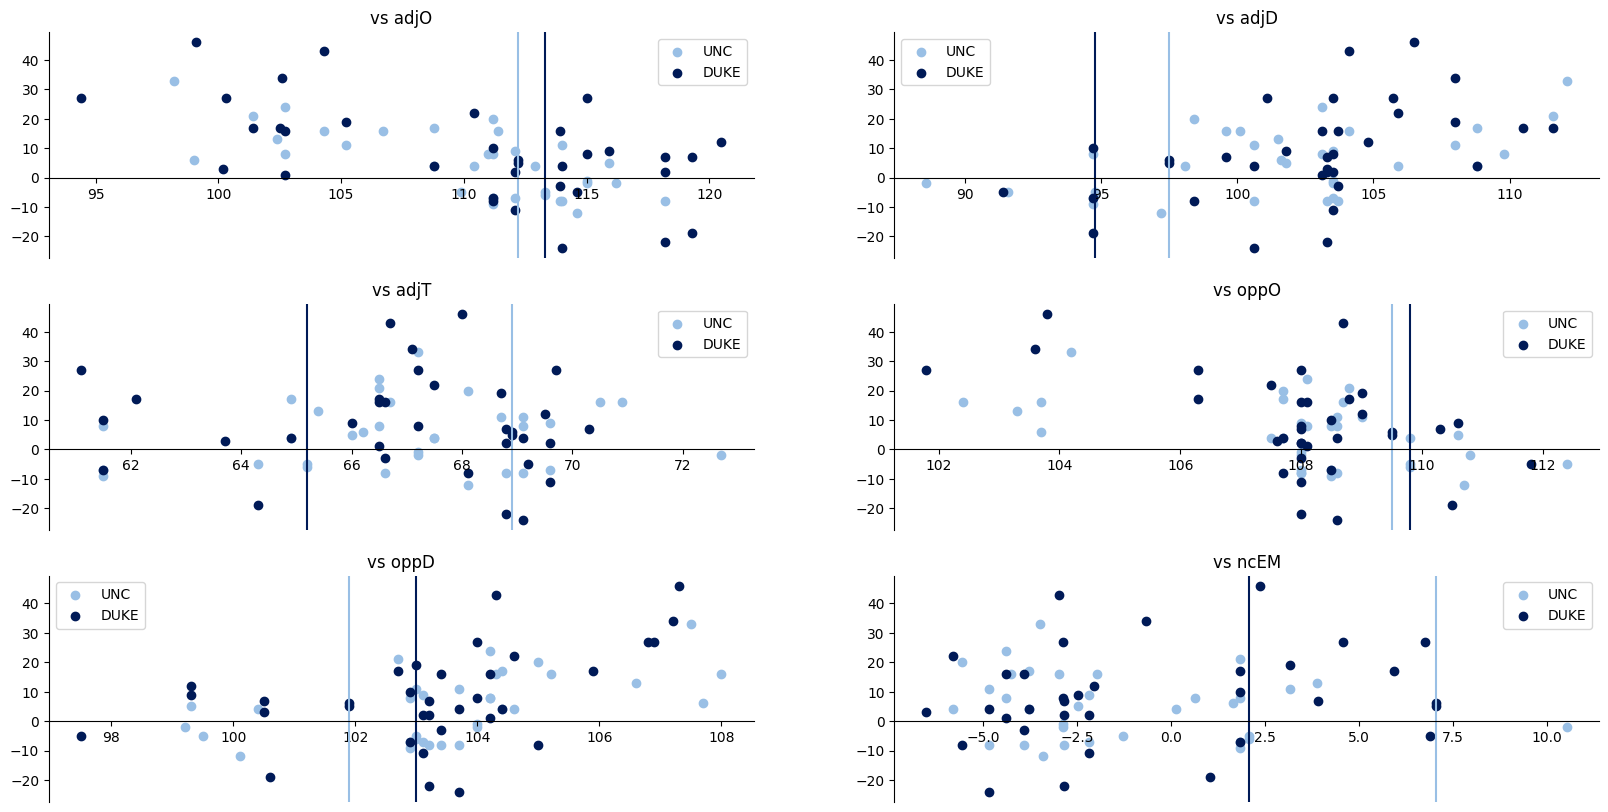

In [10]:
%matplotlib

matchupNames = ['UNC', 'Duke']


titles_funcs = [('vs adjO', lambda team: team.kp.adjO),
                ('vs adjD', lambda team: team.kp.adjD),
                ('vs adjT', lambda team: team.kp.adjT),
                ('vs oppO', lambda team: team.kp.oppO),
                ('vs oppD', lambda team: team.kp.oppD),
                ('vs ncEM', lambda team: team.kp.ncEM)]

matchupTeams = [get_team(x) for x in matchupNames]
display(kpdata(matchupTeams))

graph_stat(matchupTeams, titles_funcs)
